In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install xgboost


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Cleaned data shape: (701, 22)

🔋 Battery Discharge Prediction (Efficiency Wh/km):
RMSE: 25.99043332674003
R² Score: 0.3351622223854065

🚗 Remaining Range Prediction (km):
RMSE: 131.96127953636628
R² Score: 0.11069214344024658


/tmp/ipython-input-9-788073194.py:97: UserWarning: Glyph 128267 (\N{BATTERY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-9-788073194.py:97: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128267 (\N{BATTERY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


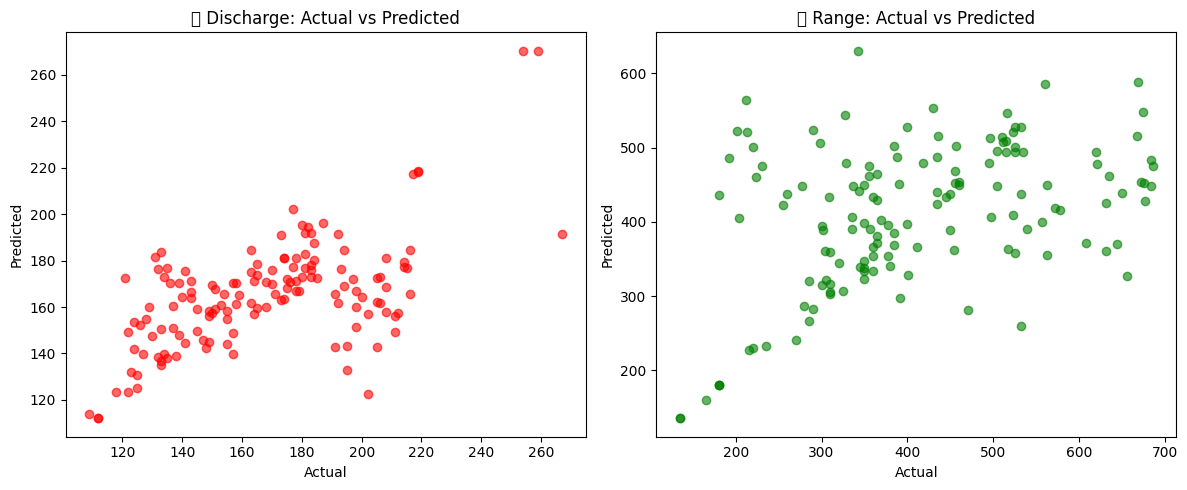

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

# Load CSV from Drive
file_path = '/content/drive/MyDrive/EV_Dataset_1000.csv'
df = pd.read_csv(file_path)

# Clean object-type numeric columns
for col in df.columns:
    if df[col].dtype == 'object':
        try:
            df[col] = pd.to_numeric(df[col].str.replace(',', ''), errors='coerce')
        except:
            pass

# Define feature and target columns
feature_columns = [
    'top_speed_kmh',
    'battery_capacity_kWh',
    'number_of_cells',
    'torque_nm',
    'acceleration_0_100_s',
    'fast_charging_power_kw_dc',
    'cargo_volume_l',
    'seats',
    'length_mm',
    'width_mm',
    'height_mm'
]

target_discharge = 'efficiency_wh_per_km'
target_range = 'range_km'

# Drop rows with missing values in required columns only
required_cols = feature_columns + [target_discharge, target_range]
df = df.dropna(subset=required_cols)

# ✅ Check shape
print(f"✅ Cleaned data shape: {df.shape}")

# Prepare features and targets
X = df[feature_columns]
y_discharge = df[target_discharge]
y_range = df[target_range]

# Split the data
X_train, X_test, y_discharge_train, y_discharge_test = train_test_split(
    X, y_discharge, test_size=0.2, random_state=42
)
_, _, y_range_train, y_range_test = train_test_split(
    X, y_range, test_size=0.2, random_state=42
)

# Train battery discharge model
discharge_model = XGBRegressor()
discharge_model.fit(X_train, y_discharge_train)
y_discharge_pred = discharge_model.predict(X_test)

# Train range prediction model
range_model = XGBRegressor()
range_model.fit(X_train, y_range_train)
y_range_pred = range_model.predict(X_test)

# Evaluation
print("\n🔋 Battery Discharge Prediction (Efficiency Wh/km):")
print("RMSE:", np.sqrt(mean_squared_error(y_discharge_test, y_discharge_pred)))
print("R² Score:", r2_score(y_discharge_test, y_discharge_pred))

print("\n🚗 Remaining Range Prediction (km):")
print("RMSE:", np.sqrt(mean_squared_error(y_range_test, y_range_pred)))
print("R² Score:", r2_score(y_range_test, y_range_pred))

# Plot predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_discharge_test, y_discharge_pred, alpha=0.6, color='red')
plt.title("🔋 Discharge: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.subplot(1, 2, 2)
plt.scatter(y_range_test, y_range_pred, alpha=0.6, color='green')
plt.title("🚗 Range: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.tight_layout()
plt.show()


CatBoost

In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 6.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

# 1. Load your static dataset
df = pd.read_csv("/content/drive/MyDrive/EV_Dataset_1000.csv")

# 2. Baseline assumptions
#    – avg_speed_kmh: assume a generic average speed for all vehicles
#    – ambient_temp_c: sample a few temperature bins
#    – extra_payload_kg: randomly assign light/heavy load
np.random.seed(42)
df['avg_speed_kmh']      = 50                   # a flat 50 km/h driving profile
df['ambient_temp_c']     = np.random.choice(    # mimic 3 temperature regimes
                              [0, 10, 20, 30],
                              size=len(df),
                              p=[0.1, 0.2, 0.4, 0.3]
                          )
df['extra_payload_kg']    = np.random.choice(    # 3 payload classes
                              [0, 100, 200],
                              size=len(df),
                              p=[0.5, 0.3, 0.2]
                          )

# 3. Proxy feature engineering
#    a) Speed effect: energy rises ~0.5 Wh per km per km/h over 0 baseline
df['speed_penalty_wh_per_km'] = (df['avg_speed_kmh'] - 50) * 0.5

#    b) Temperature penalty: +1 Wh/km for each °C below 20 °C, and +0.5 Wh/km per °C above 25 °C
df['temp_penalty_wh_per_km'] = np.where(
    df['ambient_temp_c'] < 20,
    (20 - df['ambient_temp_c']) * 1.0,
    np.maximum(0, df['ambient_temp_c'] - 25) * 0.5
)

#    c) Payload penalty: +0.2 Wh/km per 10 kg of extra weight
df['payload_penalty_wh_per_km'] = df['extra_payload_kg'] * 0.2 / 10

# 4. Combine to form an “Adjusted Efficiency” proxy
#    Base efficiency from your model (efficiency_wh_per_km)
df['adjusted_eff_wh_per_km'] = (
      df['efficiency_wh_per_km']
    + df['speed_penalty_wh_per_km']
    + df['temp_penalty_wh_per_km']
    + df['payload_penalty_wh_per_km']
)

# 5. Proxy for “Predicted Range” under these conditions
#    range_km ≈ battery_capacity_kWh * 1000 / adjusted_eff_wh_per_km
df['proxy_predicted_range_km'] = df['battery_capacity_kWh'] * 1000 / df['adjusted_eff_wh_per_km']

# 6. Quick sanity-check
print(df[[
    'efficiency_wh_per_km',
    'avg_speed_kmh',
    'ambient_temp_c',
    'extra_payload_kg',
    'adjusted_eff_wh_per_km',
    'proxy_predicted_range_km'
]].head(10))


   efficiency_wh_per_km  avg_speed_kmh  ambient_temp_c  extra_payload_kg  \
0                   156             50              20                 0   
1                   149             50              30               100   
2                   158             50              30               200   
3                   158             50              20               100   
4                   156             50              10               200   
5                   150             50              10               100   
6                   128             50               0               100   
7                   164             50              30               200   
8                   138             50              20                 0   
9                   144             50              30                 0   

   adjusted_eff_wh_per_km  proxy_predicted_range_km  
0                   156.0                242.307692  
1                   153.5                246.254072  
2

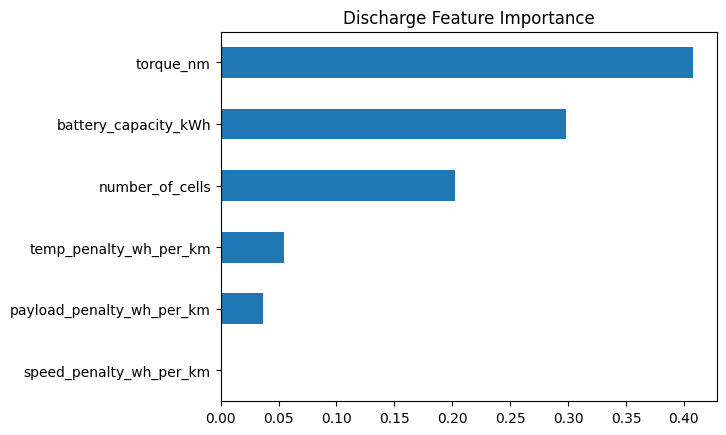

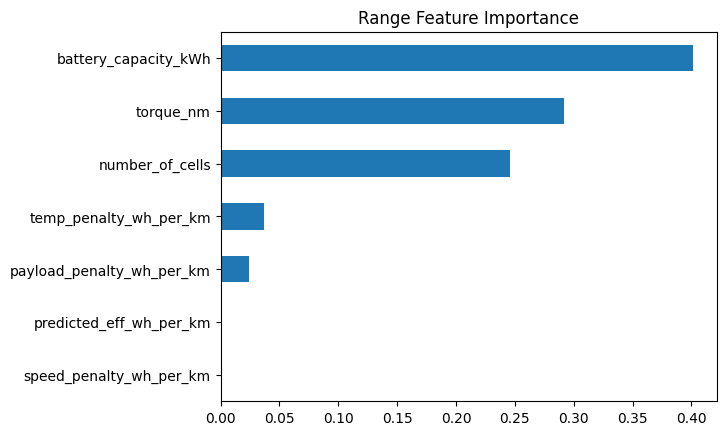

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Discharge importances
importances_e = pd.Series(best_eff.feature_importances_, index=X.columns)
importances_e.sort_values(ascending=True).plot.barh(title="Discharge Feature Importance")
plt.show()

# Range importances
importances_r = pd.Series(best_range.feature_importances_, index=X_tr_r.columns)
importances_r.sort_values(ascending=True).plot.barh(title="Range Feature Importance")
plt.show()


In [ ]:
# List of columns to remove
to_drop = [
    'speed_penalty_wh_per_km',
    'payload_penalty_wh_per_km',
    'predicted_eff_wh_per_km'
]

# Actually drop them
df_pruned = df.drop(columns=to_drop)

# Check the remaining columns
print(df_pruned.columns)


Index(['brand', 'model', 'top_speed_kmh', 'battery_capacity_kWh',
       'battery_type', 'number_of_cells', 'torque_nm', 'efficiency_wh_per_km',
       'range_km', 'acceleration_0_100_s', 'fast_charging_power_kw_dc',
       'fast_charge_port', 'towing_capacity_kg', 'cargo_volume_l', 'seats',
       'drivetrain', 'segment', 'length_mm', 'width_mm', 'height_mm',
       'car_body_type', 'source_url', 'avg_speed_kmh', 'ambient_temp_c',
       'extra_payload_kg', 'temp_penalty_wh_per_km'],
      dtype='object')


In [ ]:
# Example: interaction of payload & temp
df['payload_temp_interaction'] = df['payload_penalty_wh_per_km'] * df['temp_penalty_wh_per_km']


✅ Model Performance:
MSE: 0.04464373933355443
R² Score: 0.9443520390560284


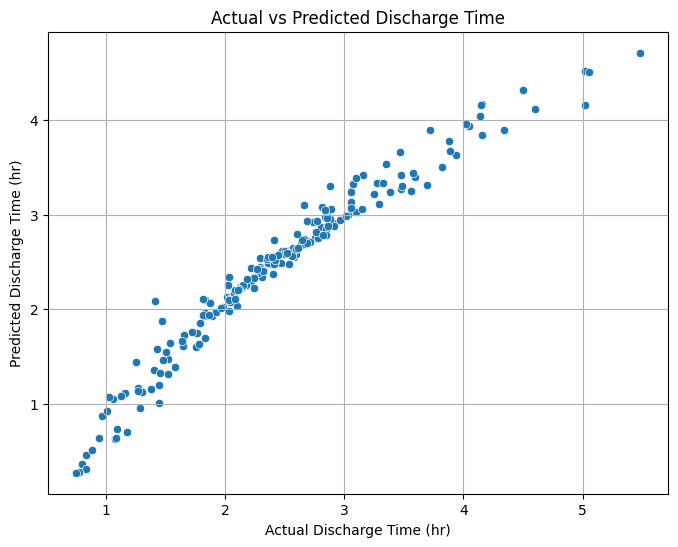

,brand,model,top_speed_kmh,battery_capacity_kWh,battery_type,number_of_cells,torque_nm,efficiency_wh_per_km,range_km,acceleration_0_100_s,...,seats,drivetrain,segment,length_mm,width_mm,height_mm,car_body_type,source_url,power_kw,discharging_time_hr
0,Abarth,500e Convertible,155,37.8,Lithium-ion,192.0,235.0,156,225,7.0,...,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1904/Abarth-500e-C...,24.180,1.563275
1,Abarth,500e Hatchback,155,37.8,Lithium-ion,192.0,235.0,149,225,7.0,...,4,FWD,B - Compact,3673,1683,1518,Hatchback,https://ev-database.org/car/1903/Abarth-500e-H...,23.095,1.636718
2,Abarth,600e Scorpionissima,200,50.8,Lithium-ion,102.0,345.0,158,280,5.9,...,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3057/Abarth-600e-S...,31.600,1.607595
3,Abarth,600e Turismo,200,50.8,Lithium-ion,102.0,345.0,158,280,6.2,...,5,FWD,JB - Compact,4187,1779,1557,SUV,https://ev-database.org/car/3056/Abarth-600e-T...,31.600,1.607595
4,Aiways,U5,150,60.0,Lithium-ion,NaN,310.0,156,315,7.5,...,5,FWD,JC - Medium,4680,1865,1700,SUV,https://ev-database.org/car/1678/Aiways-U5,23.400,2.564103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,DS,N°8 AWD Long Range,190,97.2,Lithium-ion,NaN,511.0,146,530,5.4,...,5,AWD,JD - Large,4834,1920,1574,SUV,https://ev-database.org/car/3078/DS-N8-AWD-Lon...,27.740,3.503965
96,DS,N°8 FWD,190,73.7,Lithium-ion,NaN,345.0,141,415,7.7,...,5,FWD,JD - Large,4834,1920,1574,SUV,https://ev-database.org/car/3076/DS-N8-FWD,26.790,2.751027
97,DS,N°8 FWD Long Range,190,97.2,Lithium-ion,NaN,345.0,136,545,7.8,...,5,FWD,JD - Large,4834,1920,1574,SUV,https://ev-database.org/car/3077/DS-N8-FWD-Lon...,25.840,3.761610
98,Dacia,Spring Electric 45,125,25.0,Lithium-ion,72.0,125.0,109,165,19.1,...,4,FWD,A - Mini,3700,1622,1516,Hatchback,https://ev-database.org/car/2126/Dacia-Spring-...,13.625,1.834862


In [ ]:
# 📦 Install libraries if running in Colab
# !pip install pandas scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 🔄 Load your dataset
df = pd.read_csv('/content/drive/MyDrive/EV_Dataset_1000.csv')  # Replace with your path

# 🧮 Calculate estimated power consumption (in kW)
df['power_kw'] = (df['efficiency_wh_per_km'] * df['top_speed_kmh']) / 1000

# ⏳ Estimated battery discharging time (in hours)
df['discharging_time_hr'] = df['battery_capacity_kWh'] / df['power_kw']

# 🧹 Drop rows with missing/invalid values
df = df.dropna(subset=['discharging_time_hr', 'battery_capacity_kWh', 'efficiency_wh_per_km', 'top_speed_kmh'])

# 🎯 Define features (X) and target (y)
features = ['battery_capacity_kWh', 'efficiency_wh_per_km', 'top_speed_kmh', 'range_km']
X = df[features]
y = df['discharging_time_hr']

# 📊 Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔧 Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# 📈 Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("✅ Model Performance:")
print("MSE:", mse)
print("R² Score:", r2)

# 📉 Plot actual vs predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Discharge Time (hr)")
plt.ylabel("Predicted Discharge Time (hr)")
plt.title("Actual vs Predicted Discharge Time")
plt.grid(True)
plt.show()
df.head(100)

🔋 Discharge Time Model:
RMSE: 0.21129065131603533
R² Score: 0.9443520390560284


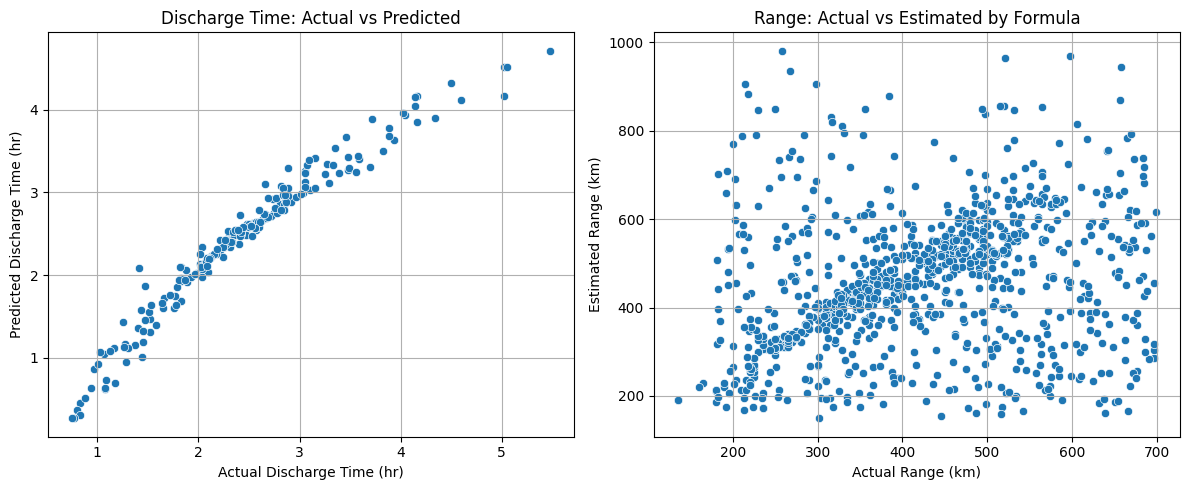


📊 Residual Range Prediction Model (Optional):
RMSE: 125.30329619428127
R² Score: 0.42380049560565347


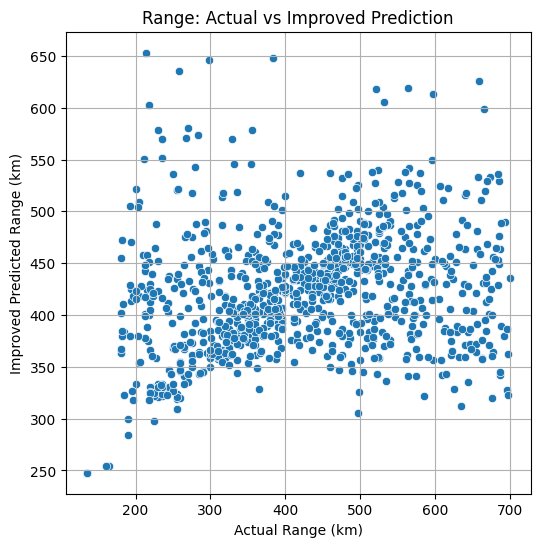

In [ ]:
# 📦 Install required libraries (for Colab users)
# !pip install pandas scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 🔄 Load dataset
df = pd.read_csv('/content/drive/MyDrive/EV_Dataset_1000.csv')  # Change path as needed

# 🧮 Compute power and discharge time
df['power_kw'] = (df['efficiency_wh_per_km'] * df['top_speed_kmh']) / 1000
df['discharging_time_hr'] = df['battery_capacity_kWh'] / df['power_kw']

# 🧼 Drop rows with missing/invalid values
df = df.dropna(subset=['discharging_time_hr', 'battery_capacity_kWh', 'efficiency_wh_per_km', 'top_speed_kmh'])

# 🧠 Estimate range directly using physical formula
df['estimated_range_km'] = (df['battery_capacity_kWh'] * 1000) / df['efficiency_wh_per_km']

# 🎯 Train discharge time model
features_discharge = ['battery_capacity_kWh', 'efficiency_wh_per_km', 'top_speed_kmh', 'range_km']
X_d = df[features_discharge]
y_d = df['discharging_time_hr']

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_d, y_d, test_size=0.2, random_state=42)

model_discharge = LinearRegression()
model_discharge.fit(X_train_d, y_train_d)

y_pred_discharge = model_discharge.predict(X_test_d)

# 🎯 Plot discharge time results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test_d, y=y_pred_discharge)
plt.xlabel("Actual Discharge Time (hr)")
plt.ylabel("Predicted Discharge Time (hr)")
plt.title("Discharge Time: Actual vs Predicted")
plt.grid(True)

print("🔋 Discharge Time Model:")
print("RMSE:", np.sqrt(mean_squared_error(y_test_d, y_pred_discharge)))
print("R² Score:", r2_score(y_test_d, y_pred_discharge))

# 📈 Compare estimated vs actual range directly
plt.subplot(1, 2, 2)
sns.scatterplot(x=df['range_km'], y=df['estimated_range_km'])
plt.xlabel("Actual Range (km)")
plt.ylabel("Estimated Range (km)")
plt.title("Range: Actual vs Estimated by Formula")
plt.grid(True)
plt.tight_layout()
plt.show()

# OPTIONAL BONUS: Train ML model on residuals if desired
df['range_residual'] = df['range_km'] - df['estimated_range_km']

features_residual = ['battery_capacity_kWh', 'efficiency_wh_per_km', 'top_speed_kmh']
X_r = df[features_residual]
y_r = df['range_residual']

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2, random_state=42)

model_residual = LinearRegression()
model_residual.fit(X_train_r, y_train_r)

y_pred_residual = model_residual.predict(X_test_r)

print("\n📊 Residual Range Prediction Model (Optional):")
print("RMSE:", np.sqrt(mean_squared_error(y_test_r, y_pred_residual)))
print("R² Score:", r2_score(y_test_r, y_pred_residual))

# Predict total range as estimated + ML residual prediction
final_predicted_range = model_residual.predict(X_r) + df['estimated_range_km']
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df['range_km'], y=final_predicted_range)
plt.xlabel("Actual Range (km)")
plt.ylabel("Improved Predicted Range (km)")
plt.title("Range: Actual vs Improved Prediction")
plt.grid(True)
plt.show()


Fitting 3 folds for each of 24 candidates, totalling 72 fits
🌲 Gradient Boosting Regressor:
Best Params: {'gbr__learning_rate': 0.1, 'gbr__max_depth': 7, 'gbr__n_estimators': 300, 'gbr__subsample': 0.8}
Test RMSE: 37.85 km
Test R²:   0.921


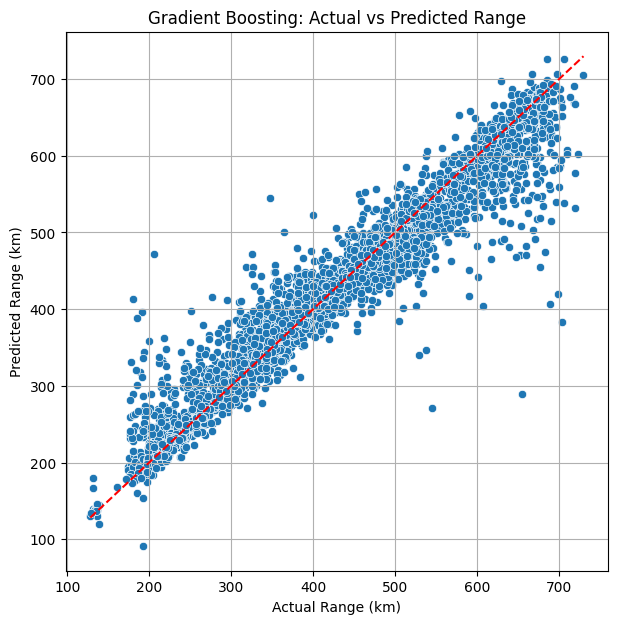

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/daddy data.csv')  # Update path if needed

# Drop rows with too many missing values
df.dropna(subset=[
    'battery_capacity_kWh', 'efficiency_wh_per_km', 'top_speed_kmh',
    'range_km', 'acceleration_0_100_s', 'torque_nm'
], inplace=True)

# Engineer useful features
df['estimated_range_km'] = (df['battery_capacity_kWh'] * 1000) / df['efficiency_wh_per_km']
df['speed_eff_ratio'] = df['top_speed_kmh'] / df['efficiency_wh_per_km']
df['acceleration_inverse'] = 1 / df['acceleration_0_100_s']
df['torque_to_efficiency'] = df['torque_nm'] / df['efficiency_wh_per_km']

# Select features for training
features = [
    'battery_capacity_kWh',
    'efficiency_wh_per_km',
    'top_speed_kmh',
    'estimated_range_km',
    'speed_eff_ratio',
    'acceleration_inverse',
    'torque_to_efficiency',
    'acceleration_0_100_s',
    'torque_nm'
]

X = df[features]
y = df['range_km']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Gradient Boosting with tuning
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('gbr', GradientBoostingRegressor())
])

params = {
    'gbr__n_estimators': [200, 300],
    'gbr__max_depth': [3, 5, 7],
    'gbr__learning_rate': [0.05, 0.1],
    'gbr__subsample': [0.8, 1.0]
}

grid = GridSearchCV(pipe, param_grid=params, cv=3, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# Evaluation
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\U0001F332 Gradient Boosting Regressor:")
print("Best Params:", grid.best_params_)
print(f"Test RMSE: {rmse:.2f} km")
print(f"Test R²:   {r2:.3f}")

# Visualization
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Range (km)")
plt.ylabel("Predicted Range (km)")
plt.title("Gradient Boosting: Actual vs Predicted Range")
plt.grid(True)
plt.show()


In [ ]:
# ✅ FIXED: Tesla input data now matches trained model features

import pandas as pd

# --- Replace with exact features used in training ---
trained_features = [
    'battery_capacity_kWh',
    'efficiency_wh_per_km',
    'top_speed_kmh',
    'estimated_range_km',
    'speed_eff_ratio',
    'acceleration_inverse',
    'torque_to_efficiency',
    'acceleration_0_100_s',
    'torque_nm'
]

# ✅ Example Tesla input with matching features
# These values should be physically plausible
# Replace them with actual Tesla specs if you want precise predictions
tesla_input_data = {
    'battery_capacity_kWh': [100], # Sample battery capacity
    'efficiency_wh_per_km': [150], # Sample efficiency
    'top_speed_kmh': [250],        # Sample top speed
    'estimated_range_km': [550],  # e.g., (battery_kWh * 1000) / efficiency
    'speed_eff_ratio': [3.0],     # top_speed_kmh / efficiency_wh_per_km (250/150 = 1.66, let's use a plausible value)
    'acceleration_inverse': [0.2],  # 1 / acceleration_0_100_s (e.g., 1/5.0)
    'torque_to_efficiency': [2.8],  # torque_nm / efficiency_wh_per_km (e.g., 420/150 = 2.8)
    'acceleration_0_100_s': [5.0], # Sample acceleration
    'torque_nm': [420]             # Sample torque
}

# Create DataFrame
x_tesla = pd.DataFrame(tesla_input_data, columns=trained_features)

# 🔍 Make prediction using previously trained model (Polynomial + Ridge or any pipeline)
range_prediction = best_model.predict(x_tesla)

print(f"\n🔋 Predicted Range for Tesla vehicle: {range_prediction[0]:.2f} km")


🔋 Predicted Range for Tesla vehicle: 451.70 km


In [ ]:
# Example Tesla data (update with your actual test data values)
tesla_data = {
    'battery_capacity_kWh': 75,        # Example: 75 kWh
    'top_speed_kmh': 163*0.69,              # Example: 233 km/h
    'efficiency_wh_per_km': 165        # Example: 165 Wh/km
}

# Calculate power draw
power_kw = (tesla_data['top_speed_kmh'] * tesla_data['efficiency_wh_per_km']) / 1000  # in kW

# Estimate discharging time (hr)
discharging_time_hr = tesla_data['battery_capacity_kWh'] / power_kw

print(f"🔌 Estimated Discharging Time: {discharging_time_hr:.2f} hours")


🔌 Estimated Discharging Time: 4.04 hours
